**Introduction**

Determining the legitimacy of an Instagram account is challenging. However, a predictive model can be constructed to gauge the probability of an account being fake, based on specific attributes and activity patterns. The objective is to classify user accounts as either genuine or counterfeit, constituting a binary classification task.

In the digital era, Instagram has emerged as a prominent platform for social interaction, personal expression, and brand establishment. Yet, alongside its popularity, the platform has witnessed a surge in fake profiles and fraudulent activities. These accounts serve various nefarious purposes, including dissemination of misinformation, phishing scams, and identity theft. Addressing this concern necessitates the application of machine learning techniques to automatically detect and eliminate fake profiles from the platform.



**Goal**

The objective is to determine if a user account is genuine or fake, which is classified as a binary classification problem due to the presence of two categories. Here, employ a combination of machine learning and deep learning models to leverage the strengths of both approaches.

# download dataset

In [ ]:
#upload api key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akumar5189","key":"2696a900cc1140e193898bd7a6284aca"}'}

In [ ]:
# prepare for api command and give permission for read and write
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!rm -rf kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d free4ever1/instagram-fake-spammer-genuine-accounts

  0% 0.00/6.81k [00:00<?, ?B/s]
100% 6.81k/6.81k [00:00<00:00, 14.2MB/s]


In [ ]:
#unzip dataset
!unzip /content/instagram-fake-spammer-genuine-accounts.zip &> /dev/null
!rm -rf /content/instagram-fake-spammer-genuine-accounts.zip

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import  accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from tensorflow.keras import utils
from tensorflow import keras
from tensorflow.keras import layers

# Load data

The initial step involves loading the data and comprehending the dataset's information structure. Following that, we implement any required alterations to the dataset before proceeding with exploratory data analysis and modeling. There are two files available: one for training and another for testing. The target vector is determined by the 'fake' column.

In [ ]:

train = pd.read_csv('train.csv') # load Training dataset
test = pd.read_csv('test.csv') # load Testing dataset
#combine data
df = pd.concat([train, test], ignore_index=True)

the features are:
- Profile Picture: Binary indicator of whether an account has a profile picture or not.

- Numerical Characters to Username Length Ratio: Continuous feature representing the proportion of numerical characters in an account's username.

- Full Name Word Count: Continuous feature indicating the total number of words in the person's full name.

- Numerical Characters to Full Name Length Ratio: Continuous feature indicating the ratio of numerical characters to the total length of the person's full name.

- Name Matches Username: Binary feature indicating whether the person's name matches their username.

- Description Length: Length of the profile description, likely the bio.

- External URL in Bio: Binary feature indicating whether a profile has a link to an external website in its bio.

- Private Profile: Binary feature indicating whether the profile is restricted to non-followers.

- Number of Posts: Continuous feature representing the total number of posts on the profile.

- Number of Followers: Continuous feature representing the total number of followers for each account.

- Number of Follows: Continuous feature representing the total number of accounts that the user is following.

- Fake Account: Target variable indicating whether an account is fake or not.

In [ ]:
df.head(4)

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0


#Exploratory Data Analysis

In [ ]:
# dataset size
print(" size of dataset :",len(df))


 size of dataset : 696


In [ ]:
# target count
target_count = df.fake.value_counts()
target_count

fake
0    348
1    348
Name: count, dtype: int64

In [ ]:
print('target have {}% for non-fake and {}% for fake.'.format(round(100*(target_count[1]/target_count.sum())),
                                                                  round(100*(target_count[0]/target_count.sum()))))

target have 50% for non-fake and 50% for fake.


In [ ]:
df.shape

(696, 12)

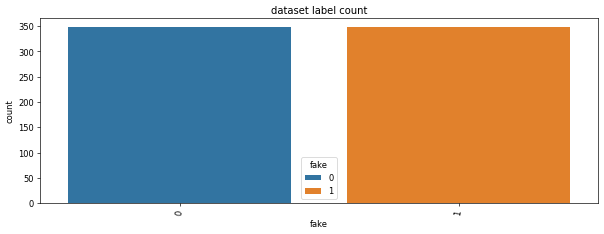

In [ ]:
# graphical analysis
plt.figure(dpi=60,figsize=(12,4))
sns.countplot(x ='fake', data=df, hue = "fake")
plt.xticks(rotation =80)
plt.title('dataset label count')
plt.show()

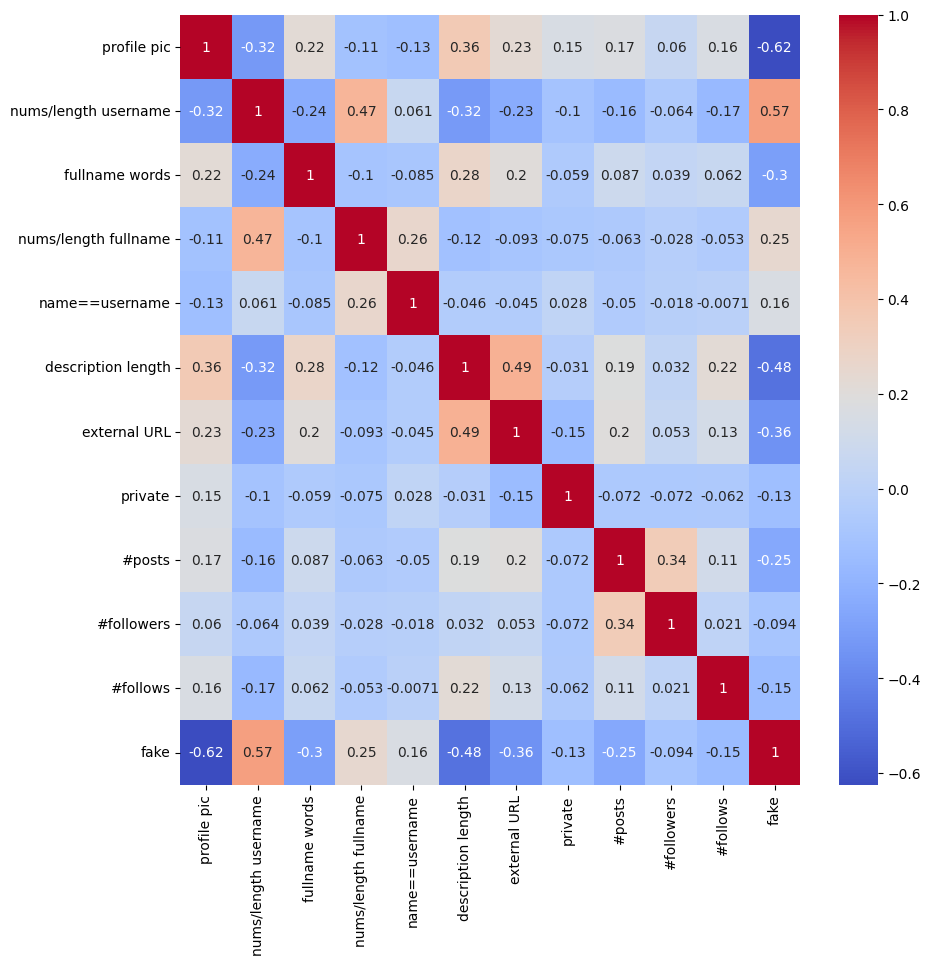

In [ ]:
# correlation between features
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

plt.show()

In [ ]:
# Check descriptive statistics
df.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,6.960000e+02,696.000000,696.00000
mean,0.711207,0.166609,1.475575,0.042170,0.035920,23.412356,0.113506,0.369253,103.244253,7.914991e+04,555.086207,0.50000
std,0.453527,0.218964,1.076622,0.143664,0.186223,38.595721,0.317438,0.482950,378.028168,8.428875e+05,1023.613869,0.50036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.200000e+01,61.000000,0.00000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.655000e+02,252.000000,0.50000
75%,1.000000,0.330000,2.000000,0.000000,0.000000,35.000000,0.000000,1.000000,77.000000,6.930000e+02,601.750000,1.00000
max,1.000000,0.920000,12.000000,1.000000,1.000000,150.000000,1.000000,1.000000,7389.000000,1.533854e+07,7500.000000,1.00000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           696 non-null    int64  
 1   nums/length username  696 non-null    float64
 2   fullname words        696 non-null    int64  
 3   nums/length fullname  696 non-null    float64
 4   name==username        696 non-null    int64  
 5   description length    696 non-null    int64  
 6   external URL          696 non-null    int64  
 7   private               696 non-null    int64  
 8   #posts                696 non-null    int64  
 9   #followers            696 non-null    int64  
 10  #follows              696 non-null    int64  
 11  fake                  696 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 65.4 KB


#Preprocessing

In [ ]:
# Check  the missing values

percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing (%)': percent_missing})
missing_value_df.sort_values('percent_missing (%)', ascending=False)

,percent_missing (%)
profile pic,0.0
nums/length username,0.0
fullname words,0.0
nums/length fullname,0.0
name==username,0.0
description length,0.0
external URL,0.0
private,0.0
#posts,0.0
#followers,0.0


In [ ]:
# check nan values
df.isna().any()

profile pic             False
nums/length username    False
fullname words          False
nums/length fullname    False
name==username          False
description length      False
external URL            False
private                 False
#posts                  False
#followers              False
#follows                False
fake                    False
dtype: bool

In [ ]:
# check  duplicated rows
df_duplicated = df[df.duplicated(keep=False)]
df_duplicated

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
196,1,0.00,2,0.0,0,48,0,0,222,5282,652,0
197,1,0.00,2,0.0,0,48,0,0,222,5282,652,0
491,1,0.91,1,0.0,0,0,0,0,0,75,26,1
525,1,0.91,1,0.0,0,0,0,0,0,75,26,1
637,1,0.27,1,0.0,0,0,0,0,0,45,64,1
639,0,0.00,1,0.0,1,0,0,0,0,69,694,1
643,0,0.00,1,0.0,1,0,0,0,0,69,694,1
659,1,0.27,1,0.0,0,0,0,0,0,45,64,1


In [ ]:
# Removing duplicates
df.drop_duplicates(inplace = True)


In [ ]:
# new dataset size
print(" size of dataset :",len(df))


 size of dataset : 692


In [ ]:
target=np.array(df['fake'])
data = df.drop('fake',axis=1)
inp_data = np.array(data)
inp_data = np.float64(inp_data)

# dataspliting

In [ ]:
# for machine learning
xtrain,xtest,ytrain,ytest = train_test_split(inp_data,target,test_size=0.2,random_state=100)

In [ ]:
# for deep learning
x_train = xtrain.reshape((xtrain.shape[0],1,xtrain.shape[1]))
x_test = xtest.reshape((xtest.shape[0],1,xtest.shape[1]))

#SVM classifier (Machine Learning)

In [ ]:


# svm training
svm = SVC()
svm.fit(xtrain,ytrain)


SVC()

In [ ]:
predictions = svm.predict(xtest)
svm_acc = accuracy_score(ytest, predictions)
print("Accuracy svm : ",svm_acc)

Accuracy svm :  0.48201438848920863


Confusion Matrix:
[[ 4 72]
 [ 0 63]]


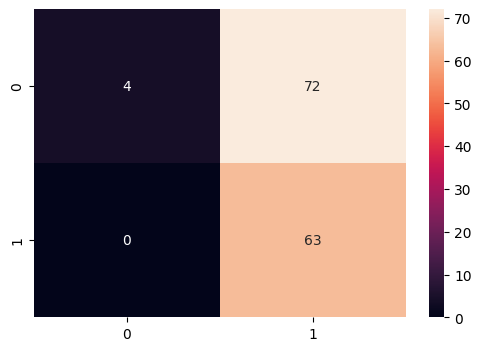

In [ ]:
cm = confusion_matrix(ytest,predictions)
print("Confusion Matrix:\n{}".format(cm))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#KNN classifier (Machine Learning)

In [ ]:

knn = KNeighborsClassifier(2).fit(xtrain, ytrain)
predictions = knn.predict(xtest)
acc = accuracy_score(ytest,predictions)
print("Accuracy knn : ", acc)

Accuracy knn :  0.8345323741007195


Confusion Matrix:
[[73  3]
 [20 43]]


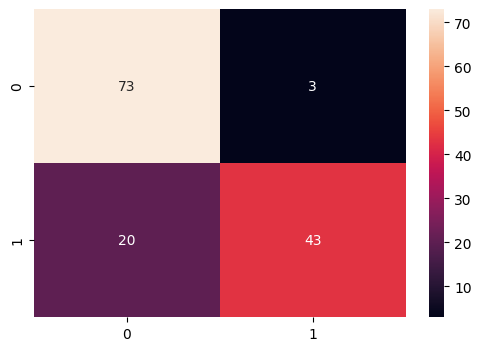

In [ ]:

cm = confusion_matrix(ytest,predictions)
print("Confusion Matrix:\n{}".format(cm))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#Multi-Layer Perceptron Classifier

In [ ]:

clf = MLPClassifier(random_state=1, max_iter=300).fit(xtrain, ytrain)


In [ ]:
predictions = clf.predict(xtest)
clf_acc = accuracy_score(ytest,predictions)
print("Accuracy MLP Classifier : ", clf_acc)

Accuracy MLP Classifier :  0.7697841726618705


Confusion Matrix:
[[74  2]
 [30 33]]


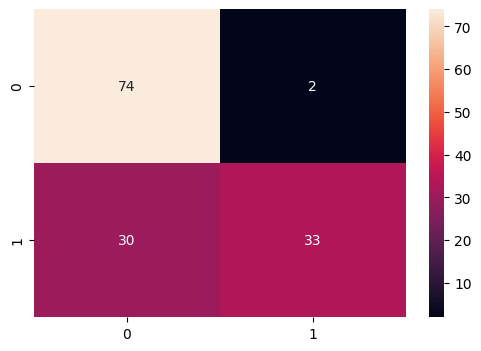

In [ ]:
cm = confusion_matrix(ytest,predictions)
print("Confusion Matrix:\n{}".format(cm))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#LSTM

In [ ]:
model = keras.Sequential()
model.add(layers.Conv1D(128,1, activation='relu',input_shape=(x_train.shape[1],11)))
model.add(layers.LSTM(25,return_sequences=True))
model.add(layers.SimpleRNN(20))
model.add(layers.Dense(400))
model.add(layers.ELU())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 128)            1536      
                                                                 
 lstm (LSTM)                 (None, 1, 25)             15400     
                                                                 
 simple_rnn (SimpleRNN)      (None, 20)                920       
                                                                 
 dense (Dense)               (None, 400)               8400      
                                                                 
 elu (ELU)                   (None, 400)               0         
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 8

In [ ]:
history = model.fit(x_train,ytrain,epochs=100, validation_split=0.2)

Epoch 1/100
14/14 [==============================] - 7s 60ms/step - loss: 0.5807 - accuracy: 0.7036 - val_loss: 0.4681 - val_accuracy: 0.8288
Epoch 2/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4671 - accuracy: 0.8258 - val_loss: 0.5514 - val_accuracy: 0.7207
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 0.5131 - accuracy: 0.7398 - val_loss: 0.5520 - val_accuracy: 0.7207
Epoch 4/100
14/14 [==============================] - 0s 10ms/step - loss: 0.4939 - accuracy: 0.7783 - val_loss: 0.4151 - val_accuracy: 0.8468
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4697 - accuracy: 0.8009 - val_loss: 0.4228 - val_accuracy: 0.8108
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 0.4618 - accuracy: 0.7805 - val_loss: 0.3998 - val_accuracy: 0.8739
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 0.4209 - accuracy: 0.8416 - val_loss: 0.4476 - val_accuracy: 0.8018
Epoch 8/100

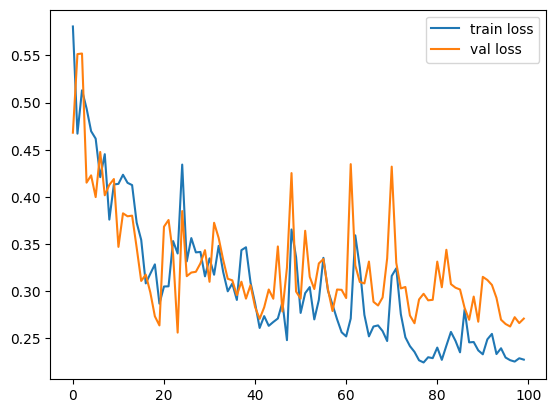

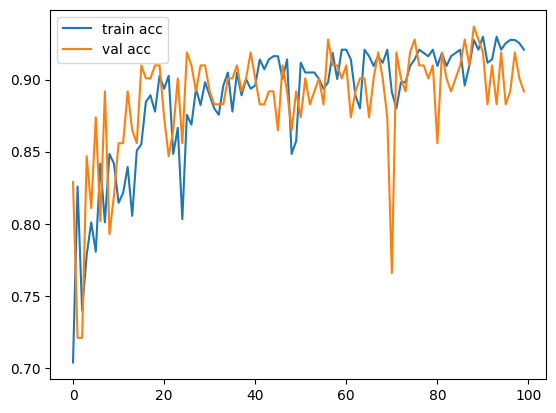

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

5/5 [==============================] - 0s 13ms/step
        Accuracy: 91.37%
Confusion Matrix:
[[69  7]
 [ 5 58]]


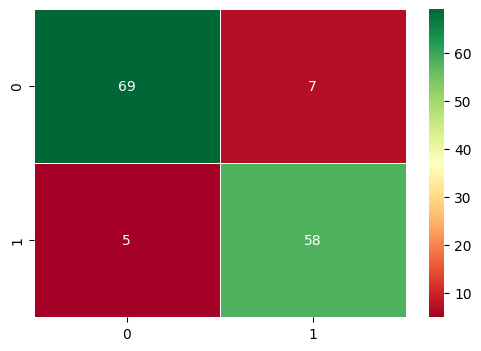

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
acc = accuracy_score(ytest, pred)
cm = confusion_matrix(ytest, pred)
print("        Accuracy: {:.2f}%".format(acc*100))
print("Confusion Matrix:\n{}".format(cm))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",cmap='RdYlGn',linewidths=0.5)
plt.show()

#fusion

In [ ]:
def get_result(xtest):
  pb2 = knn.predict_proba(xtest)
  x_test = xtest.reshape((xtest.shape[0],1,xtest.shape[1]))
  pb1 = model.predict(x_test)
  w1=0.7
  w2 =0.2
  pb = w1*pb1+w2*pb2

  pred = np.argmax(pb,axis=1)
  return pred
pred = get_result(xtest)
acc = accuracy_score(ytest, pred)
cm = confusion_matrix(ytest, pred)
print("        Accuracy: {:.2f}%".format(acc*100))
print("Confusion Matrix:\n{}".format(cm))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",cmap='RdYlGn',linewidths=0.5)
plt.show()



In [ ]:
xtest.shape

(139, 11)

#FLASK

In [ ]:
from google.colab import drive
drive.mount('mydrive')

Mounted at mydrive


In [ ]:
!unzip /content/mydrive/MyDrive/flaskapp_fake_socialmedia3.zip -d /content

In [ ]:
!pip install pyngrok -q

In [ ]:
from pyngrok import ngrok, conf
token = "2eztvNplOtga9rilPbv8NMIsfMY_5UvygYJKgBpjrirsjDcTG"
conf.get_default().auth_token = token
# Open a TCP ngrok tunnel to the SSH server
connection_string = ngrok.connect("22", "tcp").public_url

ssh_url, port = connection_string.strip("tcp://").split(":")
print(f" * ngrok tunnel available, access with `ssh root@{ssh_url} -p{port}`")

 * ngrok tunnel available, access with `ssh root@6.tcp.ngrok.io -p16769`


In [ ]:
import os
import threading
import time
from flask import Flask,render_template,request
from pyngrok import ngrok
import re
import pandas as pd

app = Flask(__name__,template_folder='templates',static_folder='static')
port = "2000"

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(public_url)
# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url

# Define Flask routes
@app.route("/")
def home():
    return render_template("home.html")
@app.route('/predict', methods=['GET','POST'])
def predict():
    input_data = []
    result = None
    if request.method == 'POST':
        input_data.append(request.form.get("profilepic").lower())
        username = request.form.get("nctulr")
        nctulr = len(re.findall(r'\d+',username))/len(username)
        input_data.append(nctulr)
        fullname = request.form.get("fnwc")
        fnwc = len(fullname.split())
        input_data.append(float(fnwc))
        nctfnlr = len(re.findall(r'\d+',fullname))/len(fullname)
        input_data.append(float(nctfnlr))
        # input_data.append(float(request.form.get("nctfnlr")))
        # input_data.append(float(request.form.get("nmun")))
        nmun = 1 if username==fullname else 0
        input_data.append(float(nmun))
        # input_data.append(float(request.form.get("dsl")))
        dsl = len(request.form.get("dsl"))
        input_data.append(float(dsl))
        input_data.append(request.form.get("urb").lower())
        input_data.append(request.form.get("pf").lower())
        input_data.append(float(request.form.get("nop")))
        input_data.append(float(request.form.get("nof")))
        input_data.append(float(request.form.get("nofs")))
        data = pd.Series(input_data)
        data = data.replace('no',0)
        data = data.replace('yes',1)
        inp = np.array(data)
        inp=inp.reshape(1,len(inp))
        res= get_result(inp)
        if res:
          result='FAKE'
        else:
          result = 'REAL'
        return render_template("result.html",result=result)
    return render_template("index.html")

@app.route("/result")
def result():
    return render_template("result.html")



# Start the Flask server in a new thread
threading.Thread(target=app.run(port=port), kwargs={"use_reloader": False}).start()

https://5e8e-34-125-214-191.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:2000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [12/Apr/2024 11:28:11] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2024 11:28:12] "GET /static/style.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2024 11:28:12] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2024 11:28:16] "GET /predict HTTP/1.1" 200 -


1/1 [==============================] - 0s 105ms/step


INFO:werkzeug:127.0.0.1 - - [12/Apr/2024 11:28:26] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2024 11:28:27] "GET /static/style2.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2024 11:28:27] "GET /script.js HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2024 11:28:32] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Apr/2024 11:28:32] "GET /static/style.css HTTP/1.1" 200 -
